In [87]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import re
from data_cleaning import *
import warnings

warnings.filterwarnings('ignore')

In [88]:
# read data
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]
X_test_raw = [x[0] for x in test_data[['text']].values]

In [89]:
#TFIDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)
X_train_tranformed, X_test_transformed = X_train_tfidf, X_test_tfidf
# chi2     
selector = SelectKBest(chi2,k=8000)
X_train_new = selector.fit_transform(X_train_tranformed,Y_train)
X_test_new = selector.transform(X_test_transformed)

In [90]:
train_size = X_train_tranformed.shape[0]
test_size = X_test_transformed.shape[0]
## random hold out
ts = test_size/train_size
X_train_, X_validation, y_train_, y_validation  = train_test_split(X_train_new,Y_train, test_size=ts)
X_train_s, y_train_s = X_train_, y_train_
cv = round(X_train_s.shape[0] / X_validation.shape[0])

In [91]:
pd.DataFrame(y_train_s).value_counts()

neutral     9086
positive    3938
negative    2679
dtype: int64

In [92]:
from sklearn.linear_model import LogisticRegression
logi_para_dict = {'solver': 'lbfgs', 'penalty': 'none', 'multi_class': 'ovr', 'max_iter': 100, 'C': 1000}
logi_model = LogisticRegression(class_weight='balanced').fit(X_train_s, y_train_s)

In [93]:
from sklearn.svm import SVC
svm_para_dict = {'max_iter': 1000, 'kernel': 'rbf', 'gamma': 1, 'degree': 3, 'decision_function_shape': 'ovr', 'C': 1000}
svm_model = SVC( class_weight='balanced').fit(X_train_s, y_train_s)


In [94]:
from sklearn.tree import DecisionTreeClassifier
dt_para_dict = {'min_samples_leaf': 8, 'max_features': 'auto','max_depth': 18, 'criterion': 'gini'}

dt_model = DecisionTreeClassifier().fit(X_train_s, y_train_s)

In [95]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
estimators = [('svm', svm_model), ('log', logi_model), ('dt', dt_model)]

In [96]:
logi_stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=200), n_jobs=-1).fit(X_train_s, y_train_s)
logi_stacking.score(X_validation, y_validation)

0.7301196917527464

In [97]:
svm_stacking = StackingClassifier(estimators=estimators, final_estimator=SVC(), n_jobs=-1).fit(X_train_s, y_train_s)
svm_stacking.score(X_validation, y_validation)

0.7396294474504017

In [98]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np
from mlxtend.evaluate import bias_variance_decomp

# this function will take the model and datas, print the evaluation scores and output the precdtion

def evaluate_model(model_name: str, model, X_validation, y_validation, X_test_new, cv=5):
    # basestic
    print(f"{model_name}: ")

    # validation acc
    validation_scores = cross_val_score(model,X_validation, y_validation, cv=cv)
    vc = np.mean(validation_scores)
    print("Validation accuracy: ",vc )
    
    print("validation acc for each cross:", validation_scores)

    # predictions for test data
    prediction = model.predict(X_test_new)

    validation_label = model.predict(X_validation)
    
    # individual metrics
    precision_m = precision_score(y_validation,validation_label, average = None)
    print('individual precision is ', precision_m)

    recall_m = recall_score(y_validation,validation_label, average = None)
    print('individual recall is ', recall_m)

    # f1
    f1_m = f1_score(y_validation,validation_label, average = None)
    print('individual f1 is ', f1_m)
    
    # macro metrics
    precision_m = precision_score(y_validation,validation_label, average = 'macro')
    print('macro precision is ', precision_m)

    recall_m = recall_score(y_validation,validation_label, average = 'macro')
    print('macro recall is ', recall_m)

    # f1
    f1_m = f1_score(y_validation,validation_label, average = 'macro')
    print('macro f1 is ', f1_m)


    # weighted metrics
    precision_w = precision_score(y_validation,validation_label, average = 'weighted')
    print('weighted precision is ', precision_w)

    recall_w = recall_score(y_validation,validation_label, average = 'weighted')
    print('weighted recall is ', recall_w)

    # f1
    f1_w = f1_score(y_validation,validation_label, average = 'weighted')
    print('weighted f1 is ', f1_w)
    
    
    return prediction

In [99]:
s_label = evaluate_model("SVM", svm_model, X_validation, y_validation,X_test_new)

SVM: 
Validation accuracy:  0.6727328231955781
validation acc for each cross: [0.67377049 0.68278689 0.66147541 0.67540984 0.67022149]
individual precision is  [0.64509395 0.78251484 0.64390244]
individual recall is  [0.5965251  0.81164288 0.62013423]
individual f1 is  [0.61985958 0.79681275 0.63179487]
macro precision is  0.6905037418477818
macro recall is  0.6761007339490256
macro f1 is  0.6828223998450215
weighted precision is  0.7253086552035242
weighted recall is  0.7283161173962944
weighted f1 is  0.7264405369300386


In [100]:
logi_label = evaluate_model("Logistic Regression", logi_model, X_validation, y_validation,X_test_new)

Logistic Regression: 
Validation accuracy:  0.6064955150015466
validation acc for each cross: [0.5795082  0.62786885 0.59754098 0.60491803 0.62264151]
individual precision is  [0.45978756 0.72894573 0.54285714]
individual recall is  [0.58494208 0.65407221 0.5738255 ]
individual f1 is  [0.51486831 0.68948222 0.55791191]
macro precision is  0.577196808841288
macro recall is  0.6042799321753897
macro f1 is  0.5874208141412421
weighted precision is  0.6377635896920599
weighted recall is  0.6227250368912937
weighted f1 is  0.6276786851083156


In [101]:
dt_label = evaluate_model("decision tree", dt_model,X_validation, y_validation,X_test_new)

decision tree: 
Validation accuracy:  0.5743588536693608
validation acc for each cross: [0.55819672 0.58770492 0.56967213 0.56721311 0.58900738]
individual precision is  [0.41194969 0.64690661 0.46534653]
individual recall is  [0.25289575 0.76966135 0.37852349]
individual f1 is  [0.31339713 0.70296524 0.41746854]
macro precision is  0.508067610132473
macro recall is  0.4670268639450253
macro f1 is  0.4779436353937668
weighted precision is  0.5626403556526565
weighted recall is  0.5863256271519921
weighted f1 is  0.5670441610799304


In [102]:
logi_s_label = evaluate_model("logi_stacking", logi_stacking, X_validation, y_validation,X_test_new)

logi_stacking: 
Validation accuracy:  0.7102812033513091
validation acc for each cross: [0.72540984 0.71311475 0.68032787 0.71721311 0.71534044]
individual precision is  [0.67011494 0.76544476 0.66566265]
individual recall is  [0.56274131 0.83571229 0.59328859]
individual f1 is  [0.61175236 0.79903666 0.62739532]
macro precision is  0.700407450295189
macro recall is  0.6639140633130794
macro f1 is  0.6793947790716665
weighted precision is  0.7248746596677996
weighted recall is  0.7301196917527464
weighted f1 is  0.7252914337158156


In [103]:
ss_label = evaluate_model("svm_stacking", svm_stacking, X_validation, y_validation,X_test_new)

svm_stacking: 
Validation accuracy:  0.7125772266975081
validation acc for each cross: [0.73360656 0.70081967 0.70491803 0.70245902 0.72108285]
individual precision is  [0.80442177 0.74646582 0.68311037]
individual recall is  [0.45656371 0.90148335 0.54832215]
individual f1 is  [0.58251232 0.81668357 0.60833954]
macro precision is  0.7446659845060628
macro recall is  0.6354564005139631
macro f1 is  0.6691784745325454
weighted precision is  0.7408325568762965
weighted recall is  0.7396294474504017
weighted f1 is  0.726007389128582


In [104]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
# logistic regression
plot_confusion_matrix(logi_model, X_validation, y_validation)
plt.show()

In [105]:
# svm
plot_confusion_matrix(svm_model, X_validation, y_validation)
plt.show()

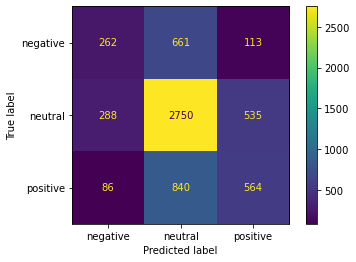

In [106]:
# decision tree
plot_confusion_matrix(dt_model, X_validation, y_validation)

In [107]:
# logi_stacking
plot_confusion_matrix(logi_stacking, X_validation, y_validation)
plt.show()

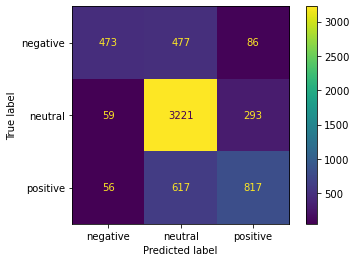

In [108]:
# svm_stacking
plot_confusion_matrix(svm_stacking, X_validation, y_validation)
plt.show()

In [109]:
pd.DataFrame(s_label).value_counts()

neutral     2487
positive    2178
negative    1434
dtype: int64

In [110]:
pd.DataFrame(logi_s_label).value_counts()

neutral     2596
positive    2034
negative    1469
dtype: int64

In [111]:
pd.DataFrame(ss_label).value_counts()

neutral     2928
positive    1984
negative    1187
dtype: int64

In [133]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_, y_train_)
resampled_labels = pd.DataFrame(y_train_smote)
resampled_labels.value_counts()

negative    9086
neutral     9086
positive    9086
dtype: int64

In [134]:
X_train_s, y_train_s = X_train_smote, y_train_smote
cv = round(X_train_s.shape[0] / X_validation.shape[0])

In [135]:
cv

4

In [136]:
from sklearn.linear_model import LogisticRegression
logi_para_dict = {'solver': 'lbfgs', 'penalty': 'none', 'multi_class': 'ovr', 'max_iter': 100, 'C': 1000}
logi_model_over = LogisticRegression(class_weight='balanced').fit(X_train_s, y_train_s)

from sklearn.svm import SVC
svm_para_dict = {'max_iter': 1000, 'kernel': 'rbf', 'gamma': 1, 'degree': 3, 'decision_function_shape': 'ovr', 'C': 1000}
svm_model_over = SVC( class_weight='balanced').fit(X_train_s, y_train_s)

from sklearn.tree import DecisionTreeClassifier
dt_para_dict = {'min_samples_leaf': 8, 'max_features': 'auto','max_depth': 18, 'criterion': 'gini'}
dt_model_over = DecisionTreeClassifier().fit(X_train_s, y_train_s)

from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
estimators = [('svm', svm_model_over), ('log', logi_model_over), ('dt', dt_model_over)]
logi_stacking_over = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=200), n_jobs=-1).fit(X_train_s, y_train_s)
svm_stacking_over = StackingClassifier(estimators=estimators, final_estimator=SVC(), n_jobs=-1).fit(X_train_s, y_train_s)

In [137]:
s_label_over = evaluate_model("SVM", svm_model_over, X_validation, y_validation,X_test_new)
logi_label_over = evaluate_model("Logistic Regression", logi_model_over, X_validation, y_validation,X_test_new)
dt_label_over = evaluate_model("decision tree", dt_model_over,X_validation, y_validation,X_test_new)
logi_s_label_over = evaluate_model("logi_stacking", logi_stacking_over, X_validation, y_validation,X_test_new)
ss_label_over = evaluate_model("svm_stacking", svm_stacking_over, X_validation, y_validation,X_test_new)

SVM: 
Validation accuracy:  0.6727328231955781
validation acc for each cross: [0.67377049 0.68278689 0.66147541 0.67540984 0.67022149]
individual precision is  [0.4978308  0.7838785  0.54306902]
individual recall is  [0.44305019 0.75118948 0.63892617]
individual f1 is  [0.46884576 0.76718594 0.5871107 ]
macro precision is  0.6082594439351041
macro recall is  0.6110552813923734
macro f1 is  0.6077141325932757
weighted precision is  0.676459002335101
weighted recall is  0.6714215445154943
weighted f1 is  0.672515904840759
Logistic Regression: 
Validation accuracy:  0.6064955150015466
validation acc for each cross: [0.5795082  0.62786885 0.59754098 0.60491803 0.62264151]
individual precision is  [0.34767557 0.73861305 0.53109756]
individual recall is  [0.67857143 0.50377834 0.58456376]
individual f1 is  [0.45977763 0.59900166 0.55654952]
macro precision is  0.5391287261833191
macro recall is  0.5889711748307255
macro f1 is  0.5384429390332622
weighted precision is  0.6215103588364872
weig

logistic regression


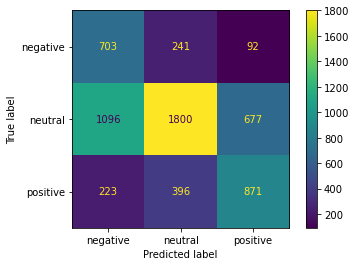

svm


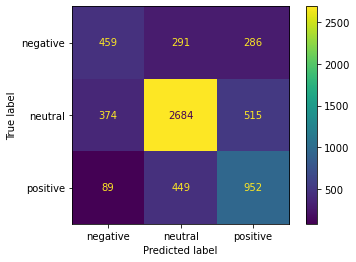

decision tree


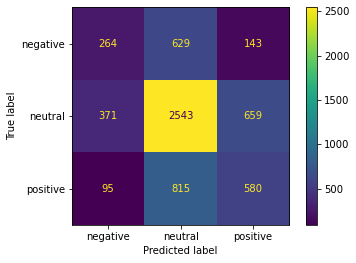

logi_stacking


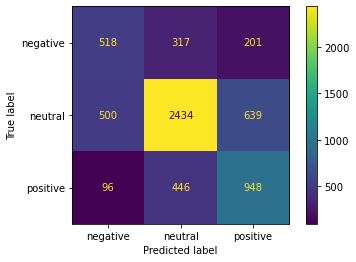

svm_stacking


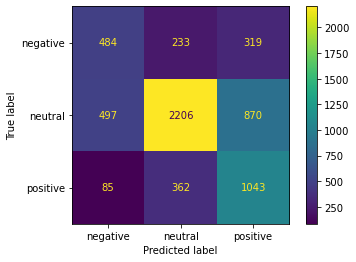

In [138]:
print('logistic regression')
plot_confusion_matrix(logi_model_over, X_validation, y_validation)
plt.show()

print('svm')
plot_confusion_matrix(svm_model_over, X_validation, y_validation)
plt.show()

print('decision tree')
plot_confusion_matrix(dt_model_over, X_validation, y_validation)
plt.show()

print('logi_stacking')
plot_confusion_matrix(logi_stacking_over, X_validation, y_validation)
plt.show()

print('svm_stacking')
plot_confusion_matrix(svm_stacking_over, X_validation, y_validation)
plt.show()

In [139]:
pd.DataFrame(logi_s_label_over).value_counts()

neutral     2787
positive    2112
negative    1200
dtype: int64

In [140]:
pd.DataFrame(logi_s_label_under).value_counts()

neutral     2596
positive    2034
negative    1469
dtype: int64

In [141]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
sampling_strategy = {'negative':2662, 'positive':2500, 'neutral': 2000}
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train_, y_train_)
X_train_s, y_train_s = X_resampled, y_resampled
cv = round(X_train_s.shape[0] / X_validation.shape[0])

In [142]:
resampled_labels = pd.DataFrame(y_train_s)
resampled_labels.value_counts()

negative    2679
neutral     2679
positive    2679
dtype: int64

In [143]:
from sklearn.linear_model import LogisticRegression
logi_para_dict = {'solver': 'lbfgs', 'penalty': 'none', 'multi_class': 'ovr', 'max_iter': 100, 'C': 1000}
logi_model_under = LogisticRegression(class_weight='balanced').fit(X_train_s, y_train_s)

from sklearn.svm import SVC
svm_para_dict = {'max_iter': 1000, 'kernel': 'rbf', 'gamma': 1, 'degree': 3, 'decision_function_shape': 'ovr', 'C': 1000}
svm_model_under = SVC( class_weight='balanced').fit(X_train_s, y_train_s)

from sklearn.tree import DecisionTreeClassifier
dt_para_dict = {'min_samples_leaf': 8, 'max_features': 'auto','max_depth': 18, 'criterion': 'gini'}
dt_model_under = DecisionTreeClassifier().fit(X_train_s, y_train_s)

from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
estimators = [('svm', svm_model_under), ('log', logi_model_under), ('dt', dt_model_under)]
logi_stacking_under = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=200), n_jobs=-1).fit(X_train_s, y_train_s)
svm_stacking_under = StackingClassifier(estimators=estimators, final_estimator=SVC(), n_jobs=-1).fit(X_train_s, y_train_s)

In [144]:
s_label_under = evaluate_model("SVM", svm_model_under, X_validation, y_validation,X_test_new)
logi_label_under = evaluate_model("Logistic Regression", logi_model_under, X_validation, y_validation,X_test_new)
dt_label_under = evaluate_model("decision tree", dt_model_under,X_validation, y_validation,X_test_new)
logi_s_label_under = evaluate_model("logi_stacking", logi_stacking_under, X_validation, y_validation,X_test_new)
ss_label_under = evaluate_model("svm_stacking", svm_stacking_under, X_validation, y_validation,X_test_new)

SVM: 
Validation accuracy:  0.6727328231955781
validation acc for each cross: [0.67377049 0.68278689 0.66147541 0.67540984 0.67022149]
individual precision is  [0.55510204 0.78002245 0.60610687]
individual recall is  [0.65637066 0.77805765 0.53288591]
individual f1 is  [0.60150376 0.77903881 0.56714286]
macro precision is  0.6470771192448158
macro recall is  0.6557714056809623
macro f1 is  0.6492284761223502
weighted precision is  0.6993286035328967
weighted recall is  0.6974913920314806
weighted f1 is  0.6971153347324012
Logistic Regression: 
Validation accuracy:  0.6064955150015466
validation acc for each cross: [0.5795082  0.62786885 0.59754098 0.60491803 0.62264151]
individual precision is  [0.3374203  0.7247012  0.52967742]
individual recall is  [0.66409266 0.509096   0.55100671]
individual f1 is  [0.44747967 0.59806017 0.54013158]
macro precision is  0.530599639548195
macro recall is  0.5747317910876818
macro f1 is  0.5285571404748457
weighted precision is  0.6112713822550915
wei

logistic regression


svm


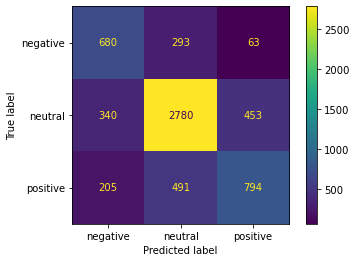

decision tree


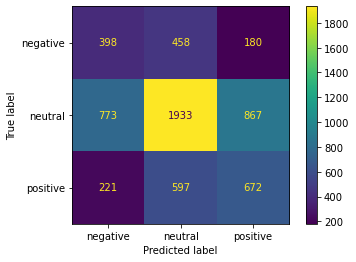

logi_stacking


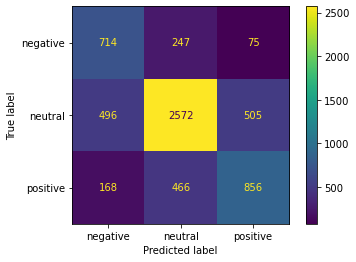

svm_stacking


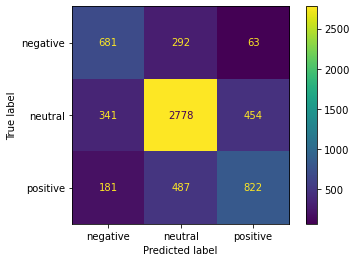

In [145]:
print('logistic regression')
plot_confusion_matrix(logi_model_under, X_validation, y_validation)
plt.show()

print('svm')
plot_confusion_matrix(svm_model_under, X_validation, y_validation)
plt.show()

print('decision tree')
plot_confusion_matrix(dt_model_under, X_validation, y_validation)
plt.show()

print('logi_stacking')
plot_confusion_matrix(logi_stacking_under, X_validation, y_validation)
plt.show()

print('svm_stacking')
plot_confusion_matrix(svm_stacking_under, X_validation, y_validation)
plt.show()

In [152]:
pd.DataFrame(ss_label_over).value_counts()

positive    2614
neutral     2333
negative    1152
dtype: int64

In [167]:
X_train_raw

[' doctors hit campaign trail as race to medical council elections heats up https://t.co/iifdwb9v0w #homeopathy',
 ' is anybody going to the radio station tomorrow to see shawn? me and my friend may go but we would like to make new friends/meet there (:\t',
 " i just found out naruto didn't become the 5th hokage....\t",
 ' "prince george reservist who died saturday just wanted to help people, his father tells @cbcnews http://t.co/riauzrjgre"\t',
 ' season in the sun versi nirvana rancak gak..slow rockkk...\t',
 " if i didnt have you i'd never see the sun. #mtvstars lady gaga\t",
 ' this is cute. #thisisus @nbcthisisus https://t.co/ndxqyl4gjk',
 ' today is the international day for the elimination of violence against women #orangetheworld #unitednations #unodc‚ä¶ https://t.co/uyqctttufj',
 ' "in his first game back since april 14, david wright went 2-for-5 with a hr, bb and three r on monday. he also made two errors at 3b."\t',
 ' josh hamilton flies out to center... we are going to the

In [189]:
# reference: https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [328]:
my_stop_words = ['they', 'its', 'them', 'and', 'to', 'the', 'be', 'to', 'in', 'and', 'of',
                 'on', 'for', 'it', 'you', 'with', 'my', 'at', 'I', 'as', 'from', 'about', 'his', 'or',
                 'she', 'your', 'an', 'this', 'that', 'we', 'here','there', 'as', 'he']

def remove_mystopwords(sentence):
    tokens = sentence.split(" ")
    tokens_filtered= [word for word in tokens if not word in my_stop_words]
    return (" ").join(tokens_filtered)

In [329]:

clean_train_texts = []
clean_test_texts = []
X_train_need_to_clean = pd.DataFrame(X_train_raw)
X_test_need_to_clean = pd.DataFrame(X_test_raw)

for i in range(len(X_train_raw)):
    text = tweet_cleaner_updated(X_train_need_to_clean[0][i])
    text = ' '.join(text_preprocessing(text, remove_html=False, punctuations=False, lowercase=False, special_chars=False, stop_words=False))
    text = remove_mystopwords(text)
    clean_train_texts.append(text)

for i in range(len(X_test_raw)):    
    text = tweet_cleaner_updated(X_test_need_to_clean[0][i])
    text = ' '.join(text_preprocessing(text, remove_html=False, punctuations=False, lowercase=False, special_chars=False, stop_words=False))
    text = remove_mystopwords(text)
    clean_test_texts.append(text)
    
X_train_clean = clean_train_texts
X_test_clean = clean_test_texts

In [330]:
X_train_clean

['doctor hit campaign trail race medical council election heat up homeopathy',
 'anybody go radio station tomorrow see shawn friend may go but would like make new friend meet',
 'just find out naruto do not become th hokage',
 'prince george reservist who die saturday just want help people father tell',
 'season sun versi nirvana rancak gak slow rockkk',
 'if do not have never see sun mtvstars lady gaga',
 'cute thisisus',
 'today international day elimination violence against woman orangetheworld unitednation unodc',
 'first game back since april david wright go hr bb monday also make error',
 'josh hamilton fly out center go bottom th tie nevereverquit',
 'watch trump protest shut down part new york city via',
 'want see basse try out some dark soul see vid below dark souls ii last giant st boss via',
 'hour shift will consist think ed sheeran tomorrow',
 'seriously debate go see paper town own tomorrow',
 'will pay back senior citizen medicare service shame',
 'stop post picture jan

In [331]:
train_cleaned_df = pd.DataFrame({'text': X_train_clean, 'target': Y_train})
test_cleaned_df = pd.DataFrame(X_test_clean)

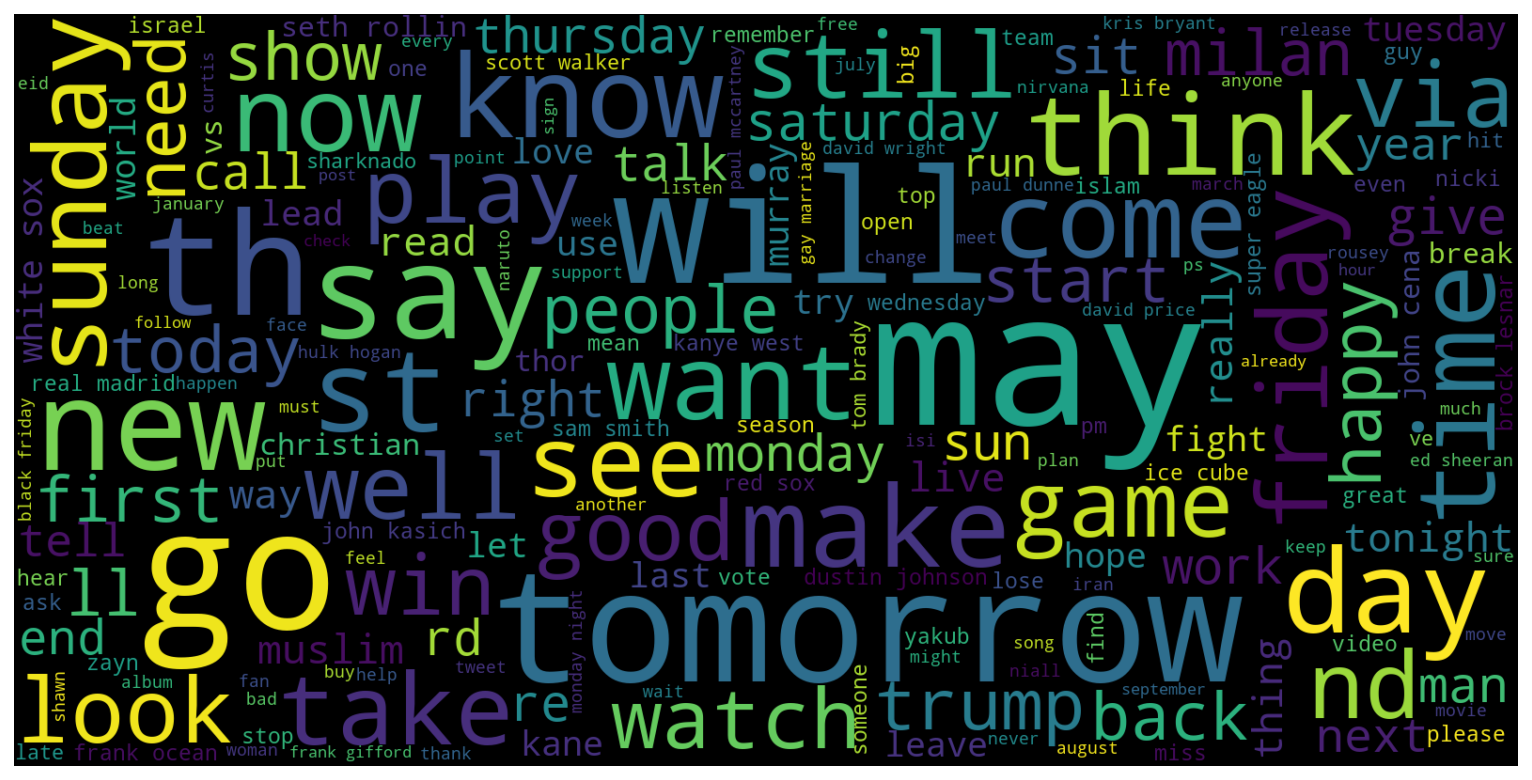

In [332]:
neutral_tweets = train_cleaned_df[train_cleaned_df.target == 'neutral']
neutral_string = []
for t in neutral_tweets.text:
    neutral_string.append(t)
neutral_string = pd.Series(neutral_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neutral_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

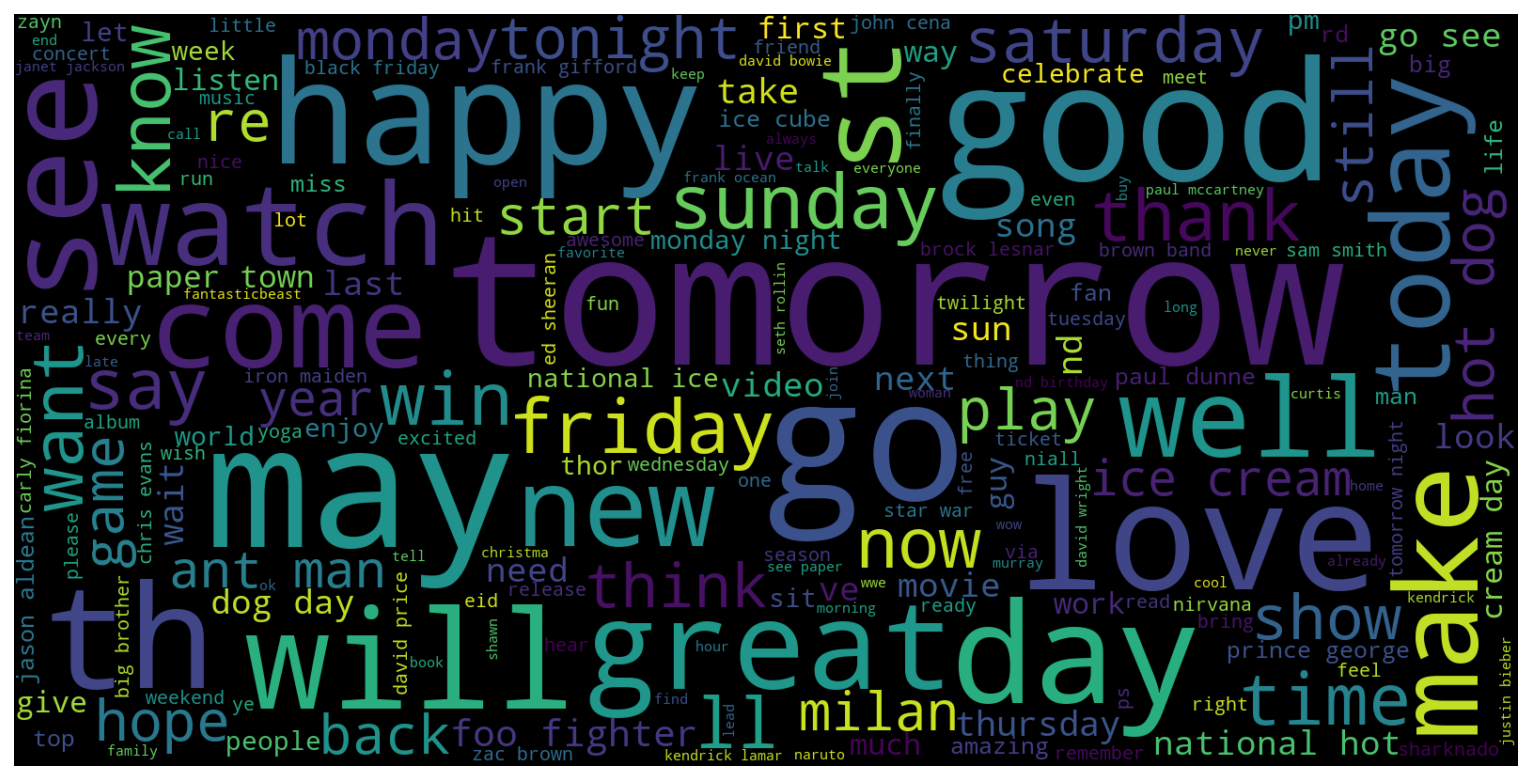

In [333]:
positive_tweets = train_cleaned_df[train_cleaned_df.target == 'positive']
positive_string = []
for t in positive_tweets.text:
    positive_string.append(t)
positive_string = pd.Series(positive_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(positive_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [334]:
negative_tweets = train_cleaned_df[train_cleaned_df.target == 'negative']
negative_string = []
for t in negative_tweets.text:
    negative_string.append(t)
negative_string = pd.Series(negative_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(negative_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [335]:
ns_pd = pd.DataFrame(neutral_string.split())
ns_pd.value_counts()

not                                                                               2088
have                                                                              1915
do                                                                                1591
may                                                                               1394
go                                                                                1145
th                                                                                1112
tomorrow                                                                          1033
but                                                                               994 
will                                                                              927 
get                                                                               849 
just                                                                              833 
if                                         

In [336]:
ps_pd = pd.DataFrame(positive_string.split())
ps_pd.value_counts()

tomorrow                             785
have                                 761
day                                  664
go                                   662
not                                  651
see                                  622
may                                  569
good                                 527
th                                   520
do                                   483
so                                   455
happy                                438
get                                  416
just                                 415
can                                  414
all                                  396
love                                 384
but                                  376
night                                370
friday                               342
like                                 328
will                                 314
time                                 290
watch                                283
out             

In [337]:
negs_pd = pd.DataFrame(negative_string.split())
negs_pd.value_counts()

not                                    1051
do                                     659 
have                                   592 
may                                    464 
but                                    372 
trump                                  325 
go                                     311 
just                                   303 
so                                     281 
will                                   269 
get                                    266 
if                                     256 
like                                   254 
all                                    247 
can                                    243 
by                                     234 
say                                    233 
no                                     221 
what                                   212 
people                                 208 
who                                    186 
tomorrow                               171 
out                             

In [338]:
X_train_clean

['doctor hit campaign trail race medical council election heat up homeopathy',
 'anybody go radio station tomorrow see shawn friend may go but would like make new friend meet',
 'just find out naruto do not become th hokage',
 'prince george reservist who die saturday just want help people father tell',
 'season sun versi nirvana rancak gak slow rockkk',
 'if do not have never see sun mtvstars lady gaga',
 'cute thisisus',
 'today international day elimination violence against woman orangetheworld unitednation unodc',
 'first game back since april david wright go hr bb monday also make error',
 'josh hamilton fly out center go bottom th tie nevereverquit',
 'watch trump protest shut down part new york city via',
 'want see basse try out some dark soul see vid below dark souls ii last giant st boss via',
 'hour shift will consist think ed sheeran tomorrow',
 'seriously debate go see paper town own tomorrow',
 'will pay back senior citizen medicare service shame',
 'stop post picture jan

In [339]:
#TFIDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)
X_test_tfidf = tfidf_vectorizer.transform(X_test_clean)
X_train_tranformed, X_test_transformed = X_train_tfidf, X_test_tfidf
# chi2     
selector = SelectKBest(chi2,k=8000)
X_train_new = selector.fit_transform(X_train_tranformed,Y_train)
X_test_new = selector.transform(X_test_transformed)
train_size = X_train_tranformed.shape[0]
test_size = X_test_transformed.shape[0]
## random hold out
ts = test_size/train_size
X_train_, X_validation, y_train_, y_validation  = train_test_split(X_train_new,Y_train, test_size=ts)
X_train_s, y_train_s = X_train_, y_train_
cv = round(X_train_s.shape[0] / X_validation.shape[0])

In [340]:
from sklearn.linear_model import LogisticRegression
logi_para_dict = {'solver': 'lbfgs', 'penalty': 'none', 'multi_class': 'ovr', 'max_iter': 100, 'C': 1000}
logi_model = LogisticRegression(class_weight='balanced').fit(X_train_s, y_train_s)
from sklearn.svm import SVC
svm_para_dict = {'max_iter': 1000, 'kernel': 'rbf', 'gamma': 1, 'degree': 3, 'decision_function_shape': 'ovr', 'C': 1000}
svm_model = SVC( class_weight='balanced').fit(X_train_s, y_train_s)
from sklearn.tree import DecisionTreeClassifier
dt_para_dict = {'min_samples_leaf': 8, 'max_features': 'auto','max_depth': 18, 'criterion': 'gini'}

dt_model = DecisionTreeClassifier().fit(X_train_s, y_train_s)
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
estimators = [('svm', svm_model), ('log', logi_model), ('dt', dt_model)]
logi_stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=200), n_jobs=-1).fit(X_train_s, y_train_s)
svm_stacking = StackingClassifier(estimators=estimators, final_estimator=SVC(), n_jobs=-1).fit(X_train_s, y_train_s)


In [341]:
s_label = evaluate_model("SVM", svm_model, X_validation, y_validation,X_test_new)
logi_label = evaluate_model("Logistic Regression", logi_model, X_validation, y_validation,X_test_new)
dt_label = evaluate_model("decision tree", dt_model,X_validation, y_validation,X_test_new)
logi_s_label = evaluate_model("logi_stacking", logi_stacking, X_validation, y_validation,X_test_new)
ss_label = evaluate_model("svm_stacking", svm_stacking, X_validation, y_validation,X_test_new)

SVM: 
Validation accuracy:  0.6807664169770976
validation acc for each cross: [0.70245902 0.70081967 0.68114754 0.6442623  0.67514356]
individual precision is  [0.61523989 0.77361996 0.63328076]
individual recall is  [0.60165593 0.82507784 0.54293442]
individual f1 is  [0.60837209 0.79852075 0.58463779]
macro precision is  0.6740468672489647
macro recall is  0.6565560621466201
macro f1 is  0.6638435434272473
weighted precision is  0.7113604372876028
weighted recall is  0.7168388260370553
weighted f1 is  0.7127649718670666
Logistic Regression: 
Validation accuracy:  0.5905884963487944
validation acc for each cross: [0.60409836 0.6        0.60163934 0.55737705 0.58982773]
individual precision is  [0.46280277 0.69237435 0.52329507]
individual recall is  [0.49218031 0.67846023 0.5240027 ]
individual f1 is  [0.47703968 0.68534668 0.52364865]
macro precision is  0.5594907297169289
macro recall is  0.5648810831383148
macro f1 is  0.56201166794909
weighted precision is  0.6104572221201667
weig

logistic regression


svm


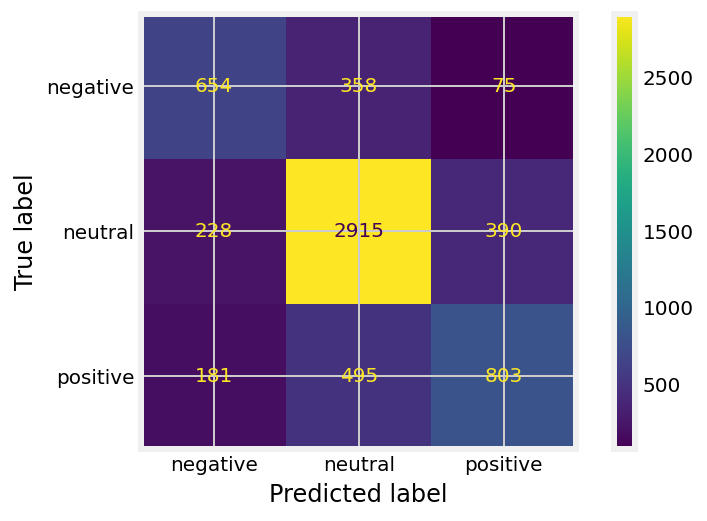

decision tree


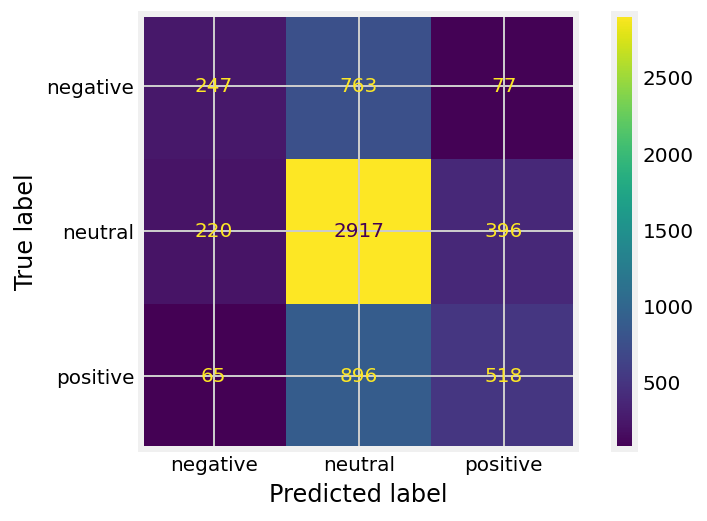

logi_stacking


svm_stacking


In [342]:
print('logistic regression')
plot_confusion_matrix(logi_model, X_validation, y_validation)
plt.show()

print('svm')
plot_confusion_matrix(svm_model, X_validation, y_validation)
plt.show()

print('decision tree')
plot_confusion_matrix(dt_model, X_validation, y_validation)
plt.show()

print('logi_stacking')
plot_confusion_matrix(logi_stacking, X_validation, y_validation)
plt.show()

print('svm_stacking')
plot_confusion_matrix(svm_stacking, X_validation, y_validation)
plt.show()

In [348]:
pd.DataFrame(logi_label).value_counts()

neutral     2995
positive    1716
negative    1388
dtype: int64

In [347]:
import csv


prediction_label = logi_s_label
with open('prediction.csv','w') as output:
    output.write("id,sentiment\n")
    for i in range(0,len(prediction_label)):
        output.write(str(test_data['id'].iloc[i]))
        output.write(",")
        output.write(prediction_label[i])
        output.write('\n')